# **Experiment No : 7**

**Name : Ashwin Kumar Ruke .   Scholar No : 24215011118**

**Q1. Image Classification Using CIFAR-10 Dataset using simple deep network with 4 hidden layers and 3 dropout layer also apply pruning and quantization to reduce size and report size of model.**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.quantization
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self):  # Fixed __init__
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.dropout3(x)
        x = self.fc5(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)


assert len(list(model.parameters())) > 0, "Model parameters are empty!"


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, epochs=10):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


train_model(model, epochs=10)


for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)


for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        prune.remove(module, 'weight')


model_quantized = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


def get_model_size(model, filename="model.pth"):
    torch.save(model.state_dict(), filename)
    size = os.path.getsize(filename) / 1024  # Size in KB
    os.remove(filename)  # Clean up
    return size

original_size = get_model_size(model, "original.pth")
pruned_size = get_model_size(model, "pruned.pth")
quantized_size = get_model_size(model_quantized, "quantized.pth")

print(f'Original model size: {original_size:.2f} KB')
print(f'Pruned model size: {pruned_size:.2f} KB')
print(f'Quantized model size: {quantized_size:.2f} KB')


100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Epoch [1/10], Loss: 2.0847
Epoch [2/10], Loss: 1.5015
Epoch [3/10], Loss: 1.5270
Epoch [4/10], Loss: 1.3566
Epoch [5/10], Loss: 1.1015
Epoch [6/10], Loss: 1.1746
Epoch [7/10], Loss: 1.1464
Epoch [8/10], Loss: 0.9774
Epoch [9/10], Loss: 0.7430
Epoch [10/10], Loss: 1.1634
Original model size: 6826.01 KB
Pruned model size: 6825.42 KB
Quantized model size: 1715.32 KB


Predicted class: 3
True class: 3


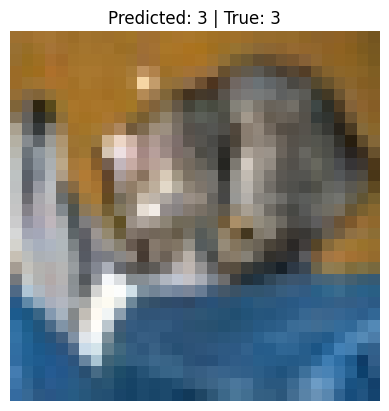

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set the model to evaluation mode


images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)


single_image = images[0].unsqueeze(0)
true_label = labels[0].item()

# Predict the class using the model
with torch.no_grad():
    output = model(single_image)
    predicted_class = torch.argmax(output, dim=1).item()

print(f"Predicted class: {predicted_class}")
print(f"True class: {true_label}")


image_np = single_image.squeeze().cpu().numpy()
image_np = np.transpose(image_np, (1, 2, 0))
image_np = image_np * 0.5 + 0.5

plt.imshow(image_np)
plt.title(f"Predicted: {predicted_class} | True: {true_label}")
plt.axis('off')
plt.show()